In [182]:
import pandas as pd
import json
import time
import datetime
import numpy as np
import xml.etree.ElementTree as ET
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
data = pd.read_csv('./data/zpozdeni.csv')

In [163]:
with open('./data/vlaky_linky.json', 'r', encoding='utf-8') as f:
    vlaky = json.loads(f.read())

In [164]:
data.drop_duplicates(subset=['train_status'], inplace=True)

In [165]:
data['stanice'] = data.train_status.apply(lambda x: x.split(' / ')[0].replace('Poslední známá poloha ', ''))
data['event'] = data.train_status.apply(lambda x: x.split(' / ')[1].split(' ')[0])
data['cas'] = data.train_status.apply(lambda x: x.split(' / ')[1].split(' ')[2])
data['datum'] = data.train_status.apply(lambda x: x.split(' / ')[1].split(' ')[1])
data['linka'] = data.vlak_cislo.apply(lambda x: vlaky[str(x)]['linka'])
data['usek'] = data.vlak_cislo.apply(lambda x: vlaky[str(x)]['usek'])

data['hodina'] = data.train_status.apply(lambda x: x.split(':')[0].split(' ')[-1])

data.zpozdeni = data.zpozdeni.astype('int')
data.hodina = data.hodina.astype('int')

In [166]:
def stamper(val):
    return time.mktime(datetime.datetime.strptime(val, "%d.%m.%Y %H:%M").timetuple())

data.tstamp = data.apply(lambda row: stamper(row['datum'] + ' ' + row['cas']), axis=1)
data.sort_values('tstamp', inplace=True)

## Odfiltrovat zastávky mimo PID

### seznam zastávek v PID

In [167]:
tree = ET.parse('./data/pid_stops.xml')
root = tree.getroot()

pid_stations = []
for group in root:
    if 'isTrain' in group.attrib:
        for attr in group.attrib:
            if 'name' in attr.lower():
                pid_stations.append(group.get(attr))
        for stop in group:
            for attr in stop.attrib:
                if 'name' in attr.lower():
                    pid_stations.append(stop.get(attr))

In [168]:
pid_stations = list(np.unique(pid_stations))

In [169]:
data = data[data.stanice.isin(pid_stations)]

## Analýza

In [170]:
data['zpozdeni'] = data.zpozdeni.apply(lambda x: 0 if x < 0 else x) #odstraněny nadjetí

In [171]:
data['u_linka'] = data.apply(lambda row: row['linka'] + ': ' + row['usek'] , axis=1)

In [173]:
out = {}
prumery = data.groupby(['u_linka', 'hodina']).zpozdeni.mean().to_dict()
for key in prumery:
    usek = key[0]
    hodina = key[1]
    val = prumery[key]
    
    if usek not in out:
        out[usek] = {}
    out[usek][int(hodina)] = val

In [174]:
hourly = data.groupby(['u_linka', 'hodina']).zpozdeni.mean().reset_index()

C:\Users\datastory\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


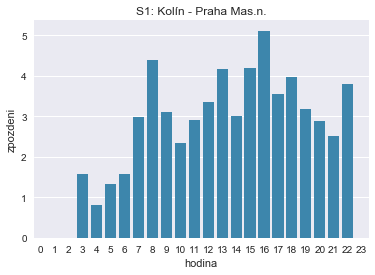

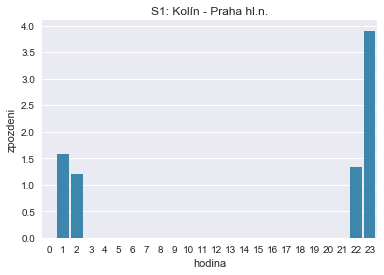

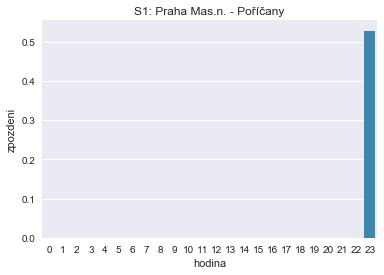

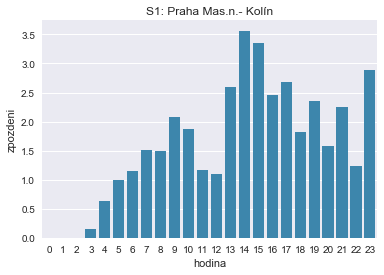

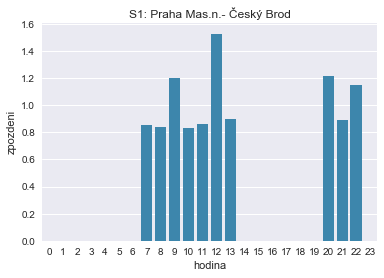

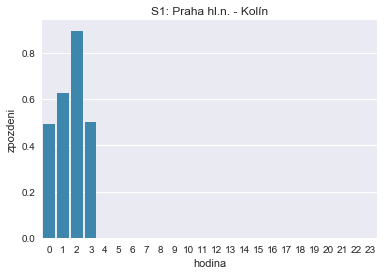

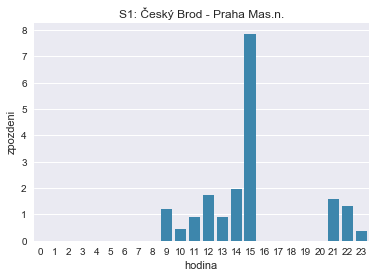

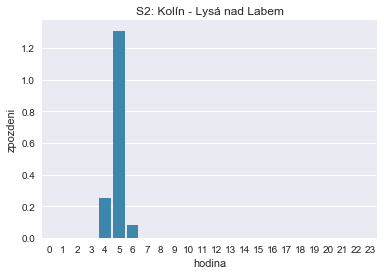

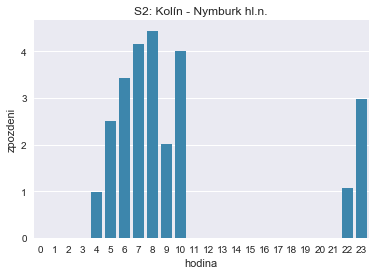

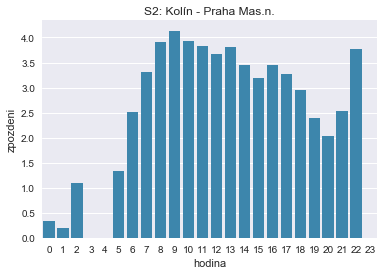

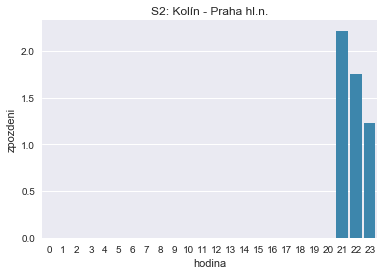

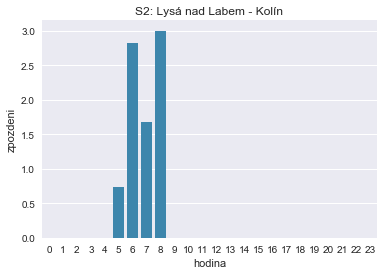

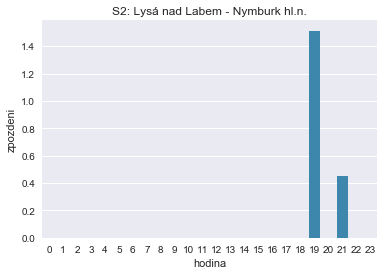

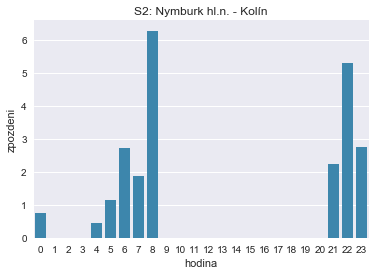

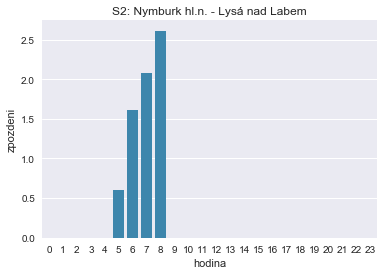

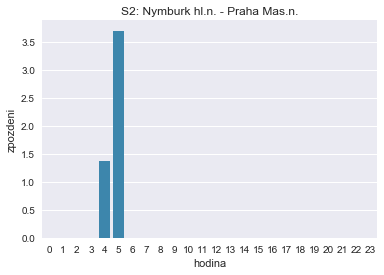

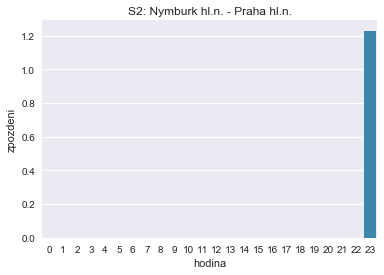

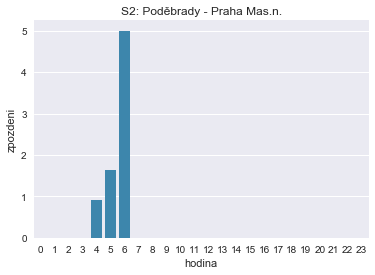

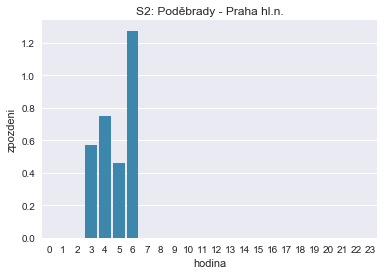

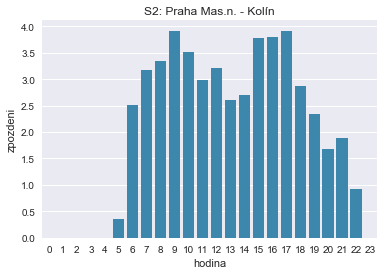

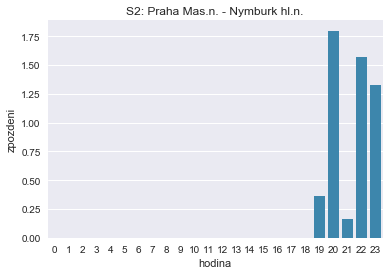

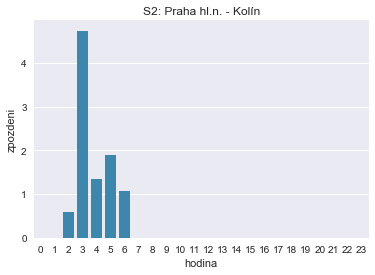

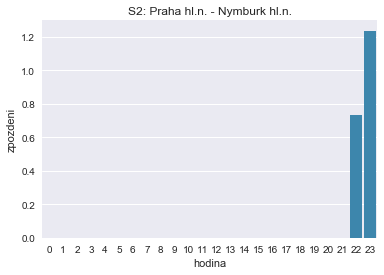

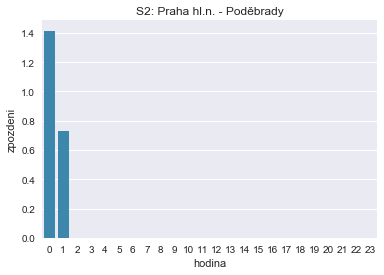

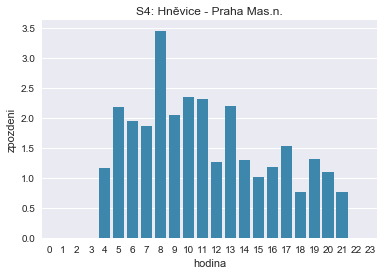

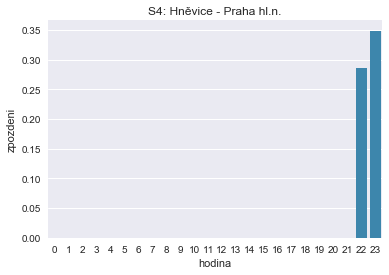

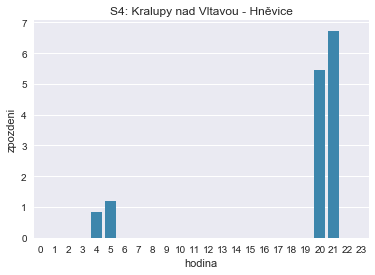

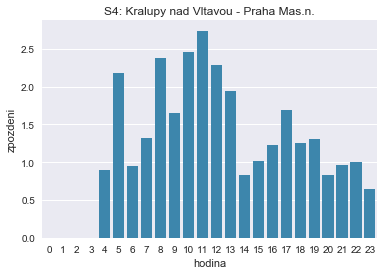

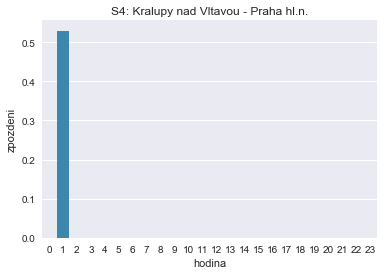

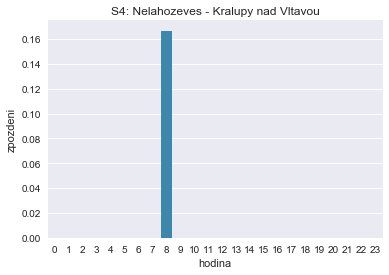

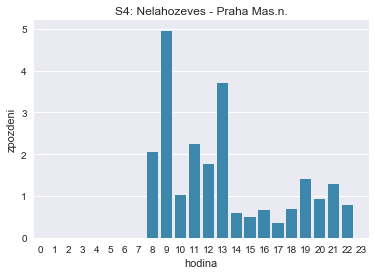

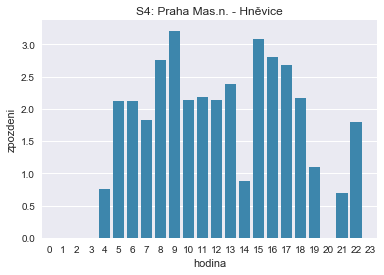

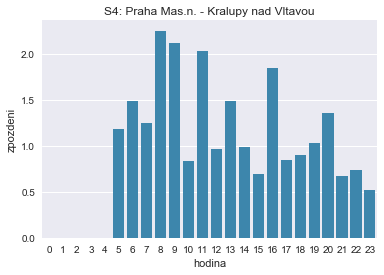

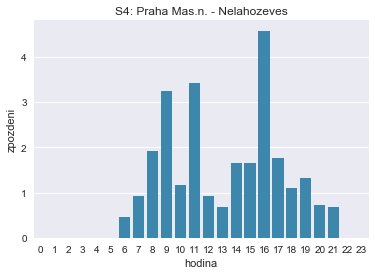

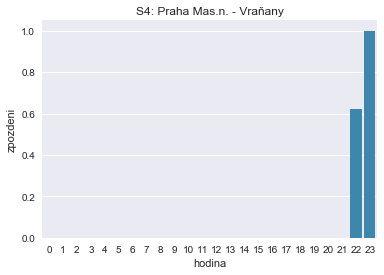

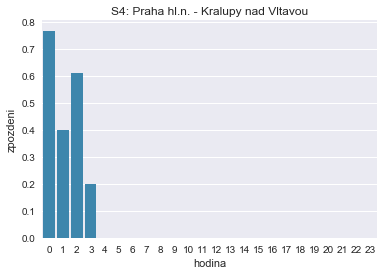

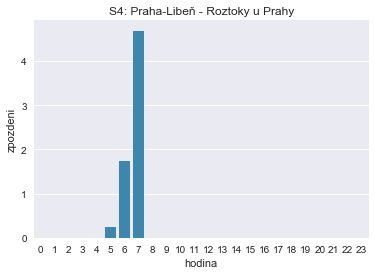

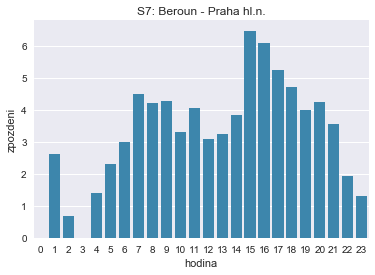

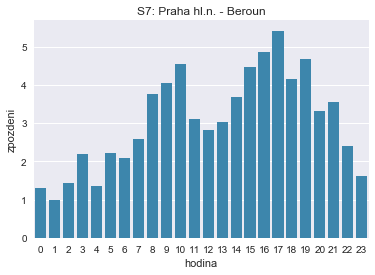

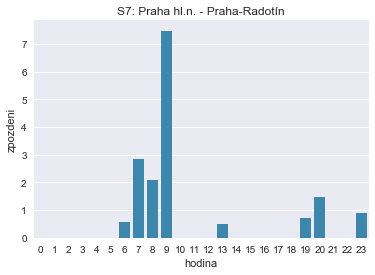

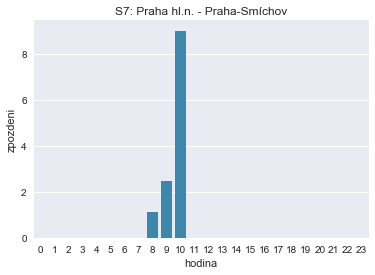

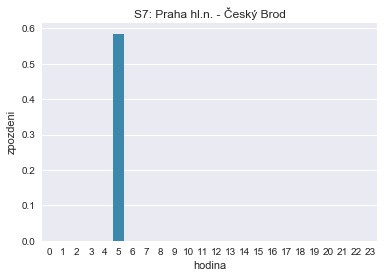

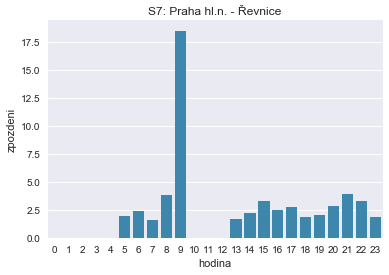

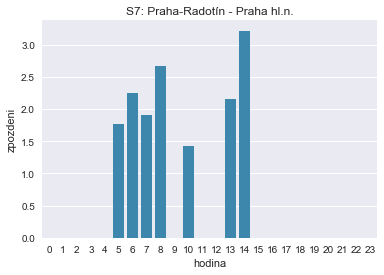

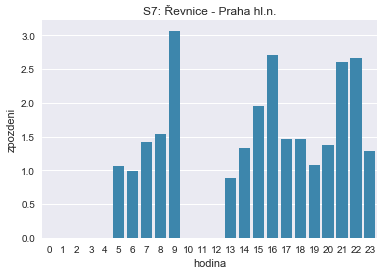

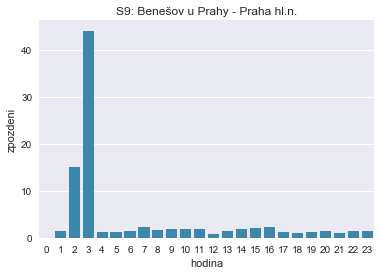

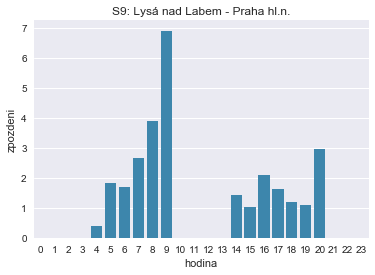

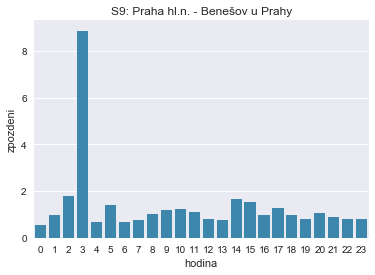

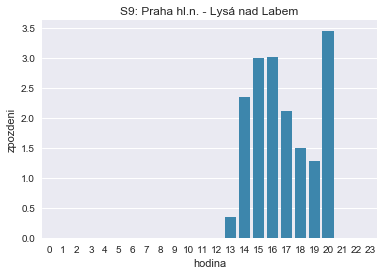

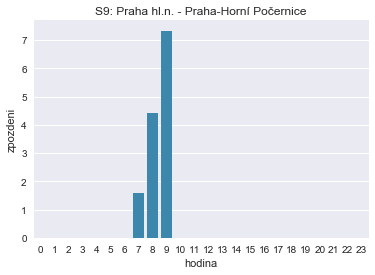

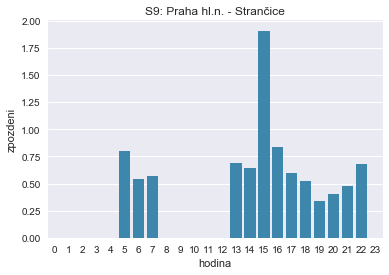

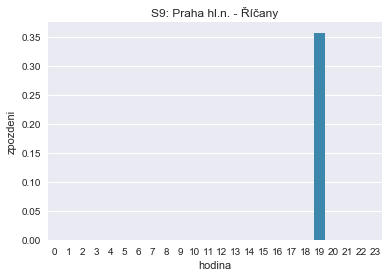

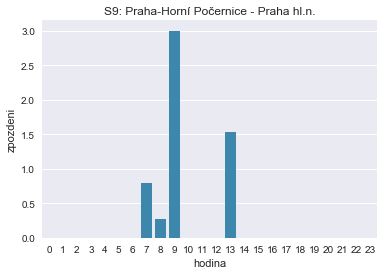

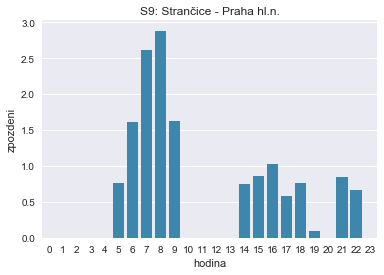

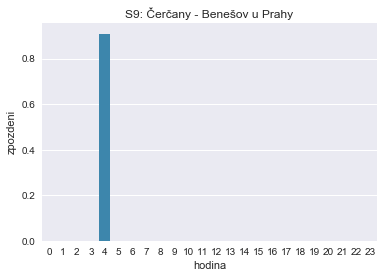

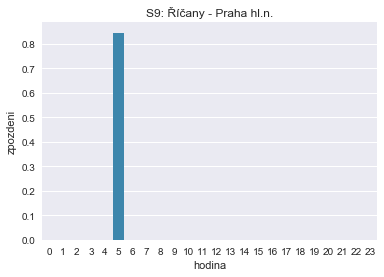

In [198]:
o = 0
for linka in hourly.u_linka.unique():
    o += 1
    plt.figure(o)
    tmp = hourly[hourly.u_linka == linka][['hodina', 'zpozdeni']].sort_values('hodina')
    for i in range(0, 24):
        if i not in tmp.hodina.values:
            tmp = tmp.append({'hodina': i, 'zpozdeni': 0}, ignore_index=True)
    
    ax = sns.barplot(x='hodina', y='zpozdeni', data=tmp, color='#2b8cbe')
    ax.set_title(linka)

In [200]:
# doplneny hodnoty pro chybejici hodiny
for rec in out:
    for i in range(0, 24):
        if i not in out[rec]:
            out[rec][i] = 0

In [201]:
with open('./js/hourly.js', 'w', encoding='utf-8') as f:
    f.write('var hourly = ' + str(out) + ';')